# Rainfall-runoff experiment

In this experiment, we'll try to learn model for simple artificial dataset of simulated rainfall-runoff scenario.

The task is to forecast runoff (prutok) based on rainfall during time. We can test longer dependencies through time and power of LSTM networks.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from tensorflow import keras
import tensorflow as tf

from tqdm.notebook import tqdm

First, we need a dataset. Here's a code that simulates one river scenario.

There are two methods: `get_precip` for rainfall and `gen_discharge` for runoff. Runoff is lagged in time based on topography of the river (see `BASINS = [BASIN(area, lag)]` array)

In [2]:
MIN_EVENT_TIME = 5
MAX_EVENT_TIME = 20
MIN_EVENT_POWER = 0.05
MAX_EVENT_POWER = 0.5

BASINS = np.array([
    (1, 5),
    (2, 20),
    (2, 30),
    (1, 35),
    (3, 41),
    (2, 45),
    (1, 54),
    (2, 65),
    (1, 75),
])

def generate_precipitation(num_samples, events_ratio):

    result = np.zeros(num_samples)
    num_events = int(events_ratio * num_samples)

    for event_start in random.sample(range(num_samples - MAX_EVENT_TIME), num_events):
        event = np.zeros((num_samples,))
        event_time = random.randint(MIN_EVENT_TIME, MAX_EVENT_TIME)
        event_power = random.random() * (MAX_EVENT_POWER - MIN_EVENT_POWER) + MIN_EVENT_POWER
        event[event_start: event_start + event_time] = (np.cos(np.linspace(-np.pi, np.pi, num=event_time)) * 0.5 + 0.5) * event_power
        result += event

    return result

def generate_discharge(basins, precip, runoff):

    volumes = np.zeros((len(basins),len(precip)))
    discharges = np.zeros((len(basins),len(precip)))
    for i, p in enumerate(precip):
        discharges[:,i] = volumes[:,i-1] * runoff
        volumes[:,i] = basins[:,0] * p + volumes[:,i-1] * (1 -runoff)


    sum_discharge = np.zeros(len(precip))
    for d, basin in zip(discharges, basins):
        lag = int(basin[1])
        lagged = np.roll(d, lag)
        lagged[:lag] = 0.0
        sum_discharge += lagged

    return sum_discharge

Let's see how our simulated river behaves:

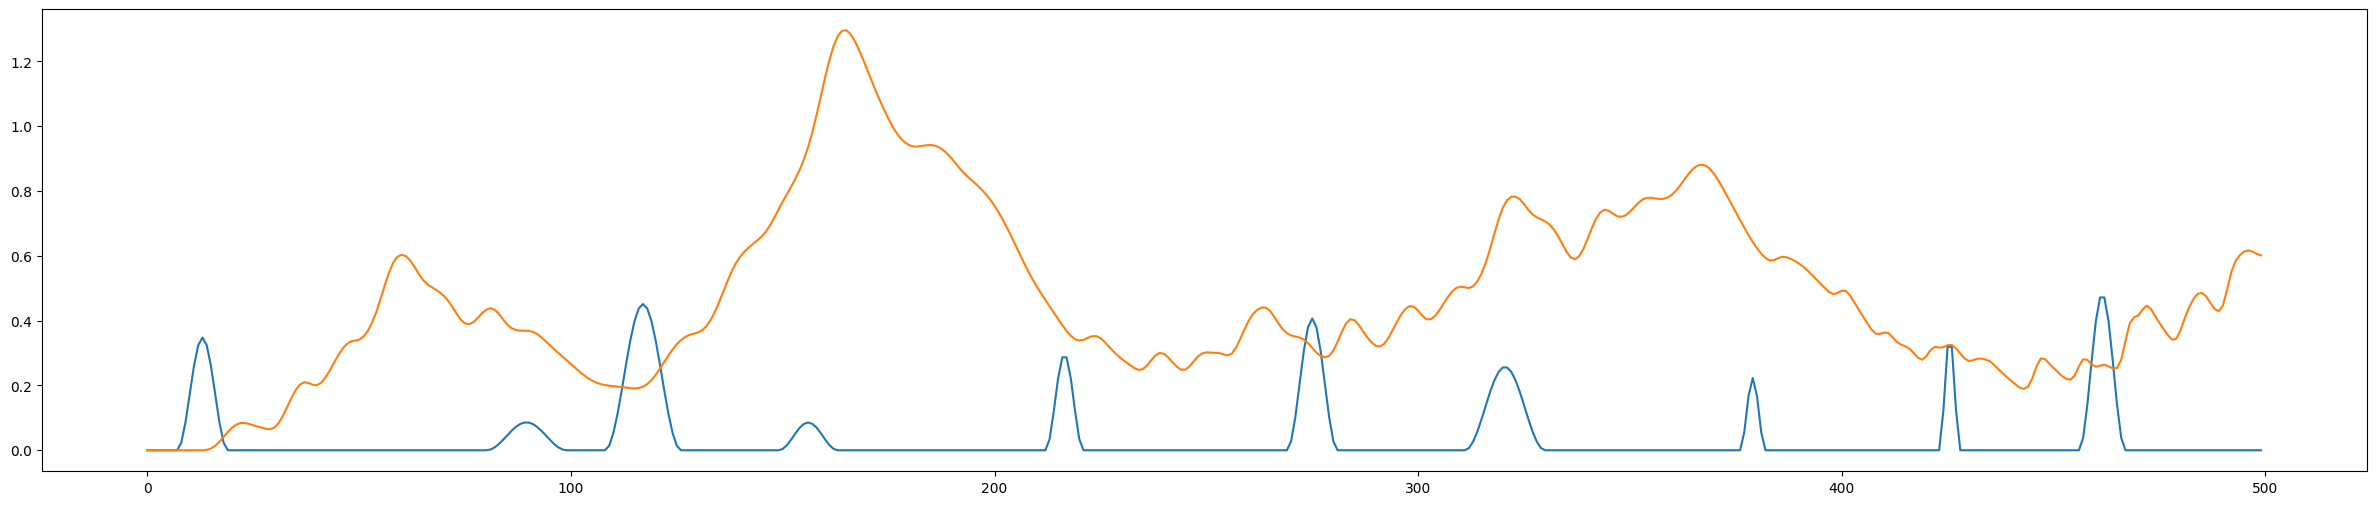

In [3]:
precip = generate_precipitation(500, 0.02)
discharge = generate_discharge(BASINS, precip, 0.05)

plt.figure(figsize=(30,6))
plt.plot(precip)
plt.plot(discharge)
plt.show()

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Generate the data
precip = generate_precipitation(500, 0.02)
discharge = generate_discharge(BASINS, precip, 0.05)

# Create a DataFrame to organize the data into a table
data = {
    'Index': range(len(precip)),
    'Precipitation': precip,
    'Discharge': discharge
}
df = pd.DataFrame(data)

# Print the table
print(df)

     Index  Precipitation  Discharge
0        0            0.0   0.000000
1        1            0.0   0.000000
2        2            0.0   0.000000
3        3            0.0   0.000000
4        4            0.0   0.000000
..     ...            ...        ...
495    495            0.0   0.669027
496    496            0.0   0.651887
497    497            0.0   0.643830
498    498            0.0   0.644961
499    499            0.0   0.652901

[500 rows x 3 columns]


We can generate some training examples for this river and try fit a neural network model to see if the model can learn the river hidden behavior.

In [25]:
import random

NUM_SAMPLES = 2000
SEQ_LEN = 500

raw_train_X = [generate_precipitation(num_samples=SEQ_LEN, events_ratio=0.01) for i in tqdm(range(NUM_SAMPLES))]
raw_train_Y = [generate_discharge(BASINS, precip_sample, 0.05) for precip_sample in tqdm(raw_train_X)]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [27]:
import random
from tqdm import tqdm

NUM_SAMPLES = 2000
SEQ_LEN = 500
ITERATIONS = 4  # Number of iterations to collect data

# Initialize empty lists for raw_train_X and raw_train_Y
raw_train_X = []
raw_train_Y = []

# Generate and collect data across multiple iterations
for iteration in range(ITERATIONS):
    print(f"Generating data for iteration {iteration + 1}/{ITERATIONS}...")
    iteration_X = [generate_precipitation(num_samples=SEQ_LEN, events_ratio=random.uniform(0.01, 0.1)) for _ in tqdm(range(NUM_SAMPLES))]
    iteration_Y = [generate_discharge(BASINS, precip_sample, 0.05) for precip_sample in tqdm(iteration_X)]
    raw_train_X.extend(iteration_X)  # Append current iteration's X data
    raw_train_Y.extend(iteration_Y)  # Append current iteration's Y data

print(f"Total samples in raw_train_X: {len(raw_train_X)}")
print(f"Total samples in raw_train_Y: {len(raw_train_Y)}")



Generating data for iteration 1/4...


100%|██████████| 2000/2000 [00:05<00:00, 384.80it/s]


Generating data for iteration 2/4...


100%|██████████| 2000/2000 [00:06<00:00, 320.46it/s]


Generating data for iteration 3/4...


100%|██████████| 2000/2000 [00:05<00:00, 380.31it/s]


Generating data for iteration 4/4...


100%|██████████| 2000/2000 [00:06<00:00, 320.41it/s]

Total samples in raw_train_X: 8000
Total samples in raw_train_Y: 8000


## Feed-forward network

In [28]:
inputs = Input(shape=(SEQ_LEN,))
x = Dense(200, activation='tanh')(inputs)
x = Dense(200, activation='tanh')(x)
x = Dense(200, activation='tanh')(x)
outputs = Dense(SEQ_LEN, activation='relu')(x)

fnn_model = Model(inputs, outputs)
fnn_model.compile(optimizer='adam', loss='mse')
fnn_model.summary()

fnn_train_X = np.vstack(raw_train_X)
fnn_train_Y = np.vstack(raw_train_Y)

print("Input shape:", fnn_train_X.shape)
print("Target shape:", fnn_train_Y.shape)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 200)                 │         100,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │         100,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,100 (1.07 MB)

 Trainable params: 281,100 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Input shape: (8000, 500)
Target shape: (8000, 500)


In [29]:
progress = fnn_model.fit(fnn_train_X, fnn_train_Y, validation_split=0.1, epochs=25)

Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5752 - val_loss: 0.0519
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0411 - val_loss: 0.0262
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0222 - val_loss: 0.0183
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0167 - val_loss: 0.0158
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_loss: 0.0110
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0106 - val_loss: 0.0120
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099 - val_loss: 0.0090
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097 - val_loss: 0.0103
Epoch 9/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 10/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0084
Epoch 11/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 12/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

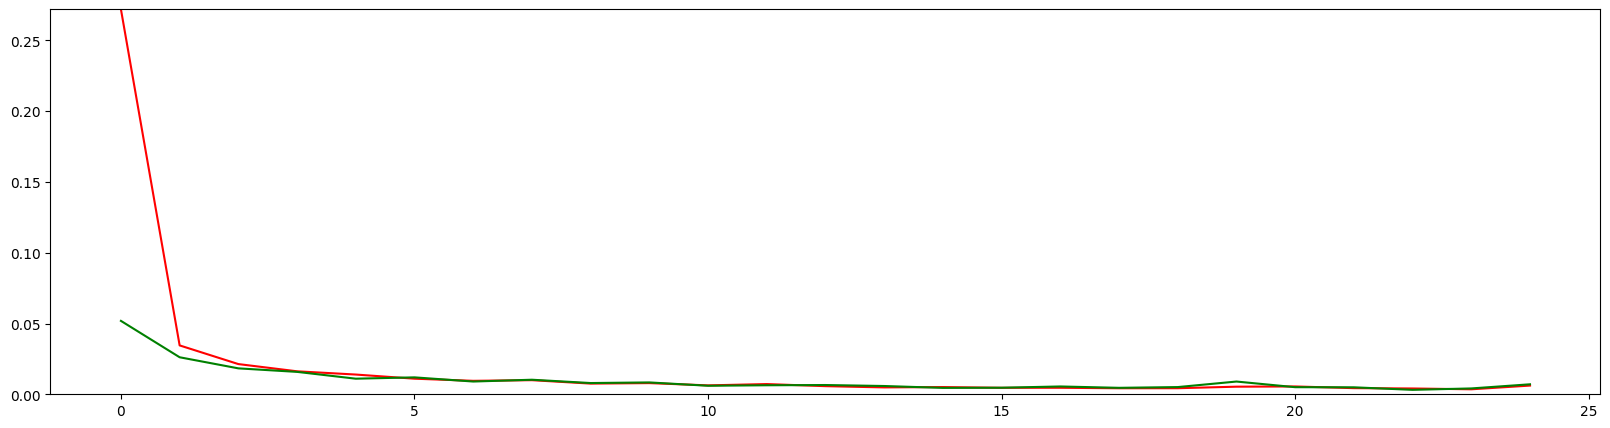

In [30]:
loss_history = np.array(progress.history['loss'])
val_loss_history = np.array(progress.history['val_loss'])

plt.figure(figsize=(20,5))
plt.ylim(ymin=0, ymax=max(np.max(loss_history), np.max(val_loss_history)))
plt.plot(loss_history, 'r-')
plt.plot(val_loss_history, 'g-')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


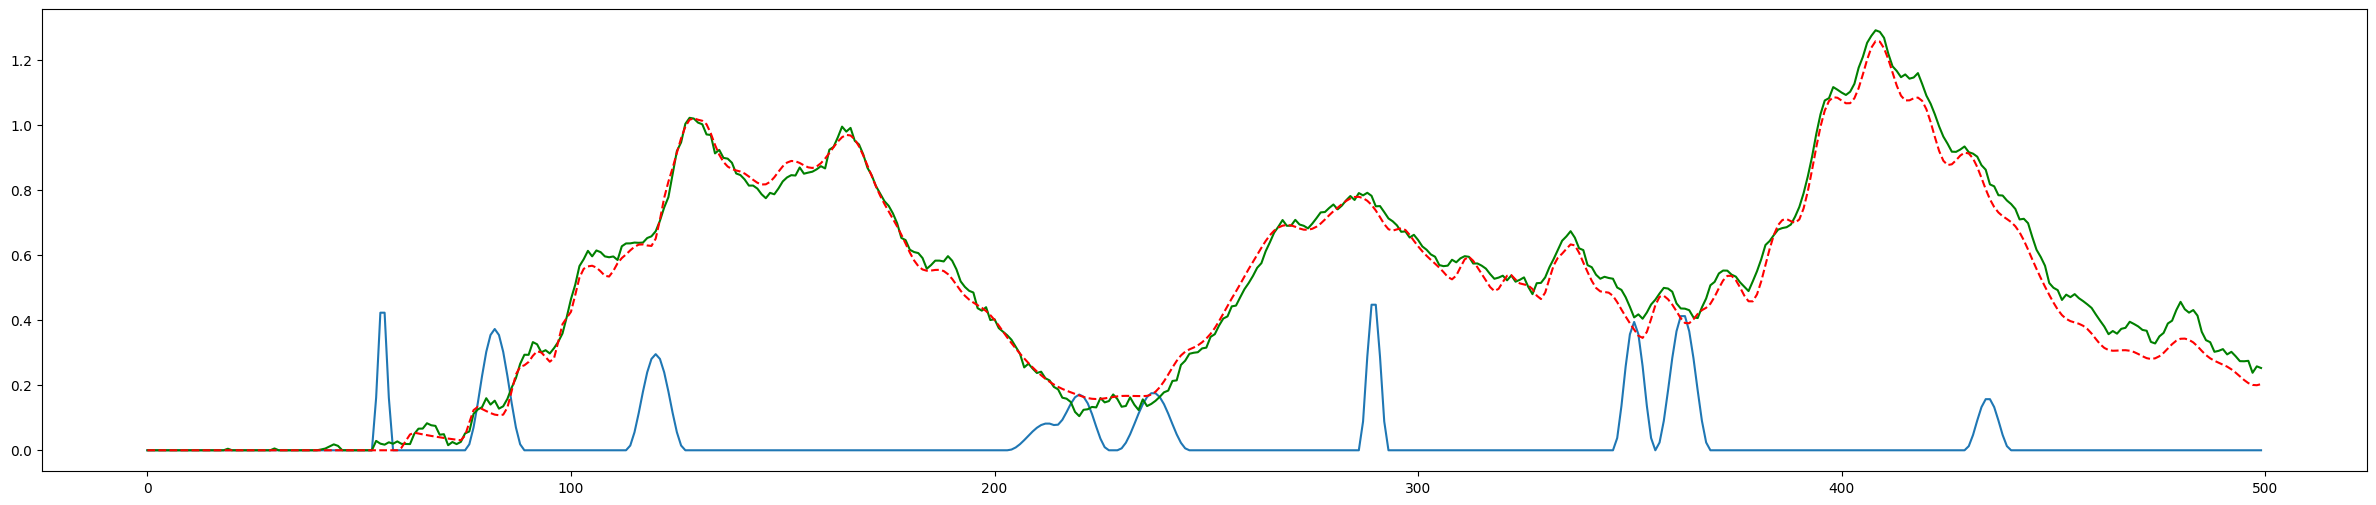

In [31]:
TEST_SEQ_LEN = 500
test_input = generate_precipitation(TEST_SEQ_LEN, 0.02)
test_output = generate_discharge(BASINS, test_input, 0.05)

prediction = fnn_model.predict(test_input.reshape(1, SEQ_LEN))[0]

plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

## Recurrent network

In [12]:
inputs = Input(shape=(None, 1))
x = LSTM(64, return_sequences=True)(inputs)
outputs = Dense(1, activation='relu')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X)
train_Y = np.vstack(raw_train_Y)

print("Input shape:", train_X.shape)
print("Target shape:", train_Y.shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 64)            │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, None, 1)             │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Input shape: (2000, 500)
Target shape: (2000, 500)


In [13]:
progress = model.fit(train_X, train_Y, validation_split=0.1, epochs=15)

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 0.2353 - val_loss: 0.1417
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0877 - val_loss: 0.0166
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0128 - val_loss: 0.0088
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0081 - val_loss: 0.0053
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 10/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 11/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 12/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

In [14]:
model.save_weights("rr_lstm.weights.h5")

In [21]:
TEST_SEQ_LEN = 2000
test_input = generate_precipitation(TEST_SEQ_LEN, 0.02)
test_output = generate_discharge(BASINS, test_input, 0.05)

In [22]:
prediction = model.predict(test_input.reshape((1, TEST_SEQ_LEN, 1)))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


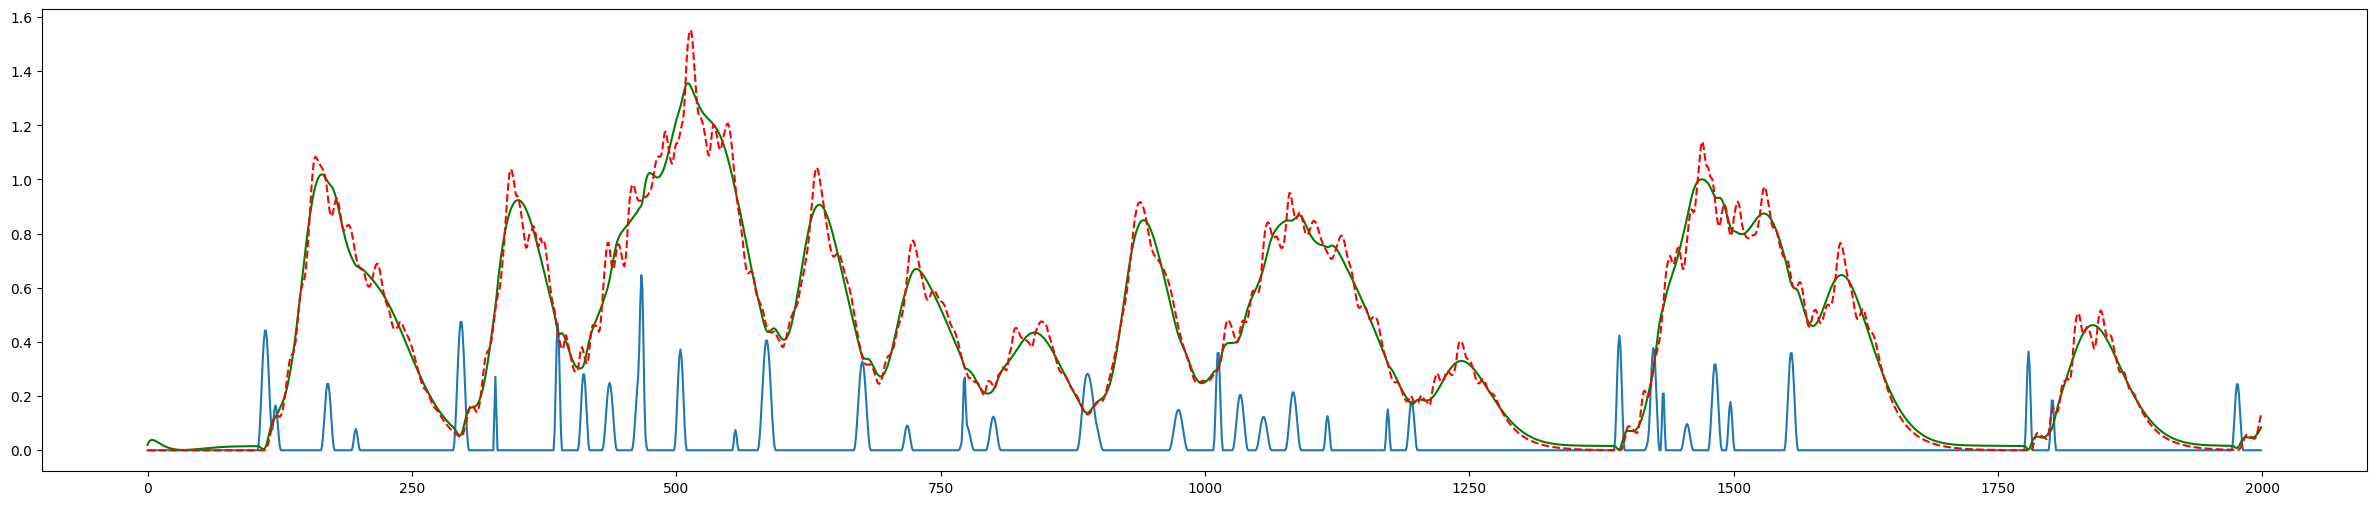

In [23]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()